# Future Impact of Ocean Acidification on Coral Reefs in the Great Barrier Reef

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Steps for predicting CO2:
1. Get the CO2 dataframe (do not exclude values past 2004, since we need these to predict future values)
2. Call plot_regression() to visualize this data and get linear regression model
3. Predict CO2 emissions up to 2050 using this linear regression model and add data to df_co2_predicted
4. Call plot_regression again to visualize old data and predicted data
5. Combine df_co2 with df_co2_predicted into df_co2_future. This can now be used to predict pH.

In [125]:
def get_australia_co2(trim_year=False):
    """Gets and cleans historic carbon emmissions data of Autralia into a DataFrame
    
    Args:
        trim_year (bool): do we want to exclude data not within 1959-2004? (default=False)
    
    Returns:
        df_co2 (DataFrame) : DataFrame containing the cleaned carbon emissions data
    """
    df_co2 = pd.read_csv('National_Carbon_Emissions_2020v1.0.csv')
    
    # Set columns to row 10
    df_co2.columns = df_co2.iloc[10]
    
    # remove all rows before row 10
    for index in df_co2.index:
        if index < 10:
            df_co2.drop(index, inplace=True)
            
    # Name the year column and delete nan values
    df_co2.rename(columns={df_co2.columns[0]:'Year'}, inplace=True)
    df_co2 = df_co2[df_co2['Year'].notna()]
    
    # Convert years to ints
    df_co2['Year'] = pd.to_numeric(df_co2['Year'])
    
    if trim_year:
        # we don't want data past 2004
        bool_series = df_co2['Year'] <= 2004
        df_co2 = df_co2.loc[bool_series, :]
    
    # set index to the year of sample taken, easier to compare to years of the other datasets
    df_co2.set_index(['Year'], inplace=True)
    
    
    # only use Australia's co2 emissions
    df_co2 = df_co2.loc[:, df_co2.columns == 'Australia']
    df_co2.rename(columns={df_co2.columns[0]:'CO2 emissions (MtC)'}, inplace=True)   
    df_co2['CO2 emissions (MtC)'] = pd.to_numeric(df_co2['CO2 emissions (MtC)'])

    
    return df_co2

df_co2 = get_australia_co2()
df_co2.head()

10,CO2 emissions (MtC)
Year,
1959,23
1960,24
1961,25
1962,26
1963,28


In [136]:
def plot_regression(x, y, x_f=None, y_f=None, title='', xlabel='', ylabel=''):
    """
    Creates scatter plot with linear regression model, plots predicted points if passed in
    
    Args:
        x (np.array): true x data
        y (np.array): true y data
        x_f (np.array): predicted x data (default=None)
        y_f (np.array): predicted y data (default=None)
        title (str): title of the plot
    Returns:
        intercept, coef (float, float): intercept and coef of the linear regression
    """
    
    reg = LinearRegression()
    reg.fit(x, y)
    y_pred = reg.predict(x)

    # compute mean squared error
    mse = ((y_pred - y) ** 2).mean()
    r2 = r2_score(y_true=y, y_pred=y_pred)

    # plot it
    plt.scatter(x, y, label='observed')
    plt.plot(x, y_pred, label='model (regression)')
        
    if x_f is not None and y_f is not None:
        plt.scatter(x_f, y_f, label='predicted')
        
    plt.legend()

    sns.set(font_scale=1.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gcf().set_size_inches(10, 5)
    plt.gca().title.set_text(title)

    # print model   
    intercept = reg.intercept_
    coef = reg.coef_[0]
    model_str = f'y = {intercept} + '
    model_str += f'{coef} x'
    
    return (intercept, coef)

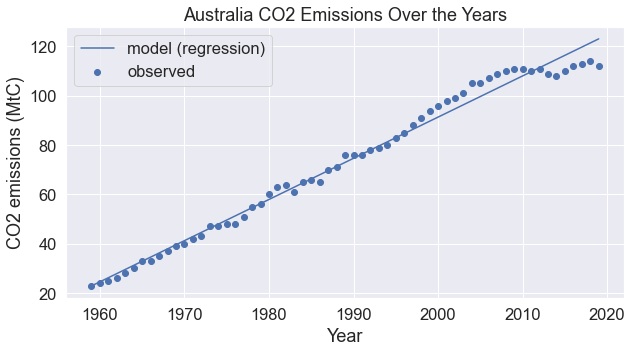

In [134]:
x = df_co2.index.astype('Int64').values
x = x.reshape((-1, 1))
y_feat = 'CO2 emissions (MtC)'
y = df_co2[y_feat]

intercept, coef = plot_regression(x, y, title='Australia CO2 Emissions Over the Years', xlabel='Year', ylabel=y_feat)

Formula for predicting CO2 emissions (y) for given year (x): y = -3247.941671073506 + 1.6696456901110523 x


In [128]:
# predict until 2050

df_co2_predicted = pd.DataFrame(columns = ['Year', y_feat])
df_co2_predicted.set_index('Year', inplace=True)

for i in range(2020, 2051):
    formula = intercept + coef * i
    df_co2_predicted.loc[i] = [formula]

df_co2_predicted.head()

,CO2 emissions (MtC)
Year,
2020,124.742623
2021,126.412269
2022,128.081914
2023,129.751560
2024,131.421206


(-3247.941671073506, 1.6696456901110523)

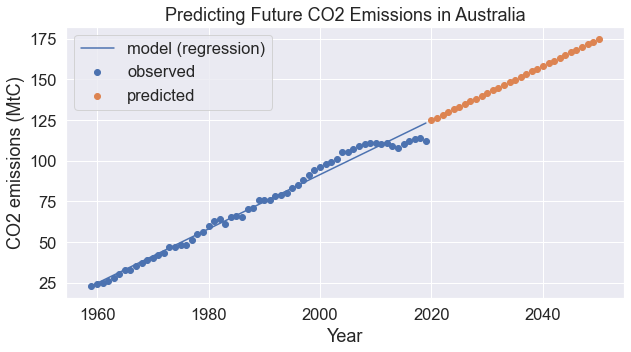

In [135]:
x_f = df_co2_predicted.index.astype('Int64').values
y_f = df_co2_predicted[y_feat]
plot_regression(x, y, x_f, y_f, title='Predicting Future CO2 Emissions in Australia', xlabel='Year', ylabel=y_feat)

In [130]:
# add predicted values to df_co2
df_co2_future = pd.concat([df_co2, df_co2_predicted])

df_co2_future

10,CO2 emissions (MtC)
Year,
1959,23.000000
1960,24.000000
1961,25.000000
1962,26.000000
1963,28.000000
...,...
2046,168.153411
2047,169.823057
2048,171.492702
